<a href="https://colab.research.google.com/github/Lucas-Buk/IMT/blob/main/SIRDataDriven.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Configurações básicas**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.integrate import odeint
import plotly.graph_objects as go

# **Referências**

https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/

https://cmdlinetips.com/2018/04/how-to-concatenate-arrays-in-numpy/

https://stackoverflow.com/questions/11278836/fitting-data-to-system-of-odes-using-python-via-scipy-numpy

# **O problema**









O conjunto de equações diferenciais que caracteriza o modelo é descrito abaixo. No modelo $\beta - \text{representa a taxa de transmissão ou taxa efetiva de contato} $  e $r - \text{a taxa de remoção ou recuperação.}$ 


$$ \begin{split}
   \frac{dS(t)}{dt} & = -\beta S(t) I(t) \\
   \frac{dI(t)}{dt} & = \beta S(t) I(t) - rI(t)  \\
   \frac{dR(t)}{dt} & = r I(t)
   \end{split}$$

   Gostaríamos de identificar quais parâmetros $\beta$ e $r$ resultam num melhor ajuste do modelo para os dados de **S**, **I** e **R**

In [2]:
def SIRmodel(y, t, Beta, r):
    S, I, R = y
    Sdot = -(Beta * S * I)
    Idot = (Beta * S * I)  - r * I
    Rdot = r * I
    return Sdot, Idot, Rdot   

# Resolução da simulação - Escala temporal (dias)

# **Obtendo** $y_s(\theta,k) = [S \; I \: R]$



O trecho a seguir retorna os valores sintetizados $y_s(\theta,k) = [S \; I \: R]$ representa o dado sintetizado a partir de um modelo sintetizado para uma determinada amostra $k$ e $\theta$ representa o vetor de parâmetros $\theta = [ \beta \; \; r]^T$. A partir de uma condição inicial $y_0$.



In [3]:
def SIRsim(y0, t, theta):
    Beta = theta[0]
    r = theta[1]
    ret = odeint(SIRmodel,y0,t,args=(Beta,r))
    S, I, R = ret.T
    return S, I, R

# **Estimativa de parâmetros**

Para estimarmos os parâmetros do modelo $\mathbf{\beta}$ e $\mathbf{r}$, vamos utilizar  inicialmente o método de mínimos quadrados. Podemos então formular o problema a partir da Equação abaixo. Na Equação $y_m(k)$ representa o dado real em cada amostra $k$; $y_s(\theta,k)$ representa o **valor estimado** a partir da simulação do modelo para uma determinada amostra $k$ e $\theta$ representa o vetor ed parâmetros $\theta = [ \beta \; \; r]^T$. 

$$ min_{\theta}= \sum_{k=1}^{K}(y_m(k) - y_s(\theta,k))^2 $$

A equação formula a pergunta: quais os valores de $\mathbf{\beta}$ e $r$ que minizam o erro quadrático quando comparados com os dados reais.

In [4]:
def ErroQuadratico(Sd, Id, Rd, y0, t, theta0):
    """ function to pass to optimize.leastsq
        The routine will square and sum the values returned by 
        this function""" 
    [S,I,R] = SIRsim(y0,t,theta0)
    erroS = S - Sd
    erroI = I - Id
    erroR = R - Rd
    EQ = np.concatenate([erroI,erroR])
    return EQ

def objetivo(p):
    return ErroQuadratico(Sd,Id,Rd,y0,t,p)

# **Dados artificiais**

Uma prática interessante na análise de dados é testarmos se o algoritmo proposto e principalmente sua estrutura está consistente. Podemos então utilizar dados artificiais para avaliar se o processo de ajuste está estruturado corretamente.

In [5]:
# Lendo o arquivo de dados no formato 'filename.csv'  
data = pd.read_csv("/content/drive/MyDrive/Trabalho/Covid/Datasets/SIRpd") 
# Preview das cinco primeiras linhas
data.head()

,S,I,R
0,499.000000,1.000000,0.000000
1,498.949042,1.040746,0.010213
2,498.896013,1.083146,0.020841
3,498.840830,1.127267,0.031903
4,498.783405,1.173179,0.043415


In [6]:
data.shape

(1000, 3)

In [7]:
s_array = data[["S", "I", "R"]].to_numpy()
s_array[:,0:]
Sd = s_array[:,0]
Id = s_array[:,1]
Rd = s_array[:,2]

**Gerando ruído gaussiano**

In [8]:
Sdn = np.random.normal(0, np.mean(Sd)/10, len(Sd)) 
Idn = np.random.normal(0, np.mean(Id)/5, len(Sd)) 
Rdn = np.random.normal(0, np.mean(Rd)/10, len(Sd)) 

**Adicionando aos dados**

In [9]:
Sd = Sd + Sdn
Id = Id + Idn
Rd = Rd + Rdn

**Visualizando os dados**

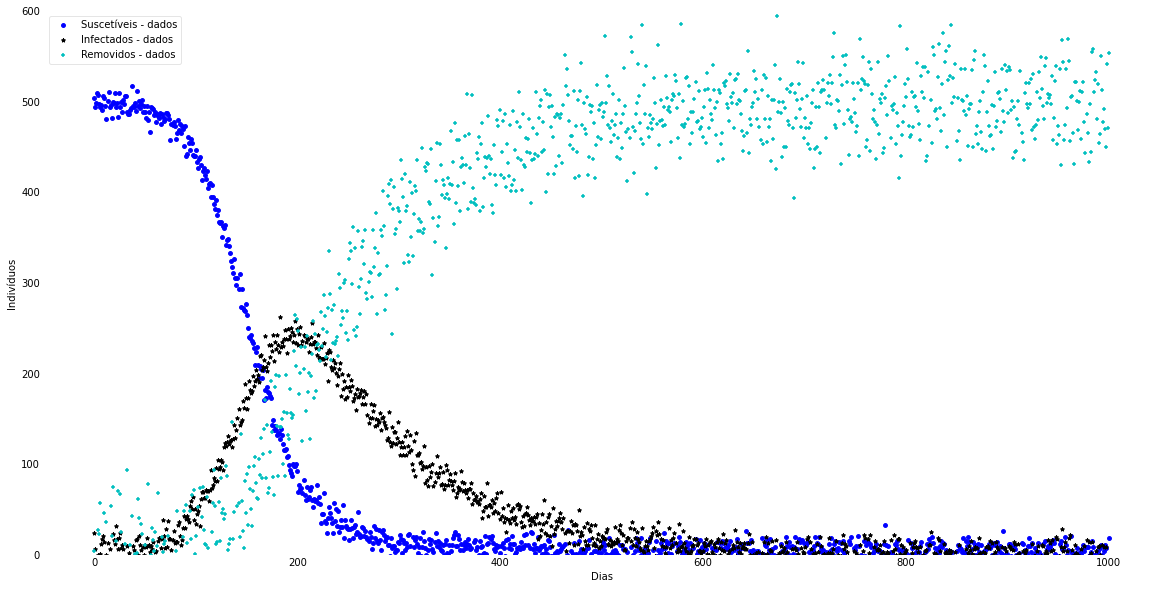

In [10]:
# Visualizando a evolução da Epidemia - S(t), I(t) e R(t)
t = np.linspace(0,len(Sd),len(Sd))
fig = plt.figure(facecolor='w',figsize=(20,10))
ax = fig.add_subplot(111, axisbelow=True)
plt.scatter(t, Sd, marker='o', color='b', label='Suscetíveis - dados', s=15)
plt.scatter(t, Id, marker='*', color='k', label='Infectados - dados', s=15)
plt.scatter(t, Rd, marker='+', color='c', label='Removidos - dados', s=15)
ax.set_xlabel('Dias')
ax.set_ylabel('Indivíduos')
ax.set_ylim(0,600)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## **Condições inicias** - $y_0$ e $\theta_0$

In [11]:
# Tamanho da população - N
N = 500

# Valores iniciais 
I0 = 1 
R0 = 0
S0 = N - I0

# Vetor de condições iniciais
y0 = S0, I0, R0

# Beta -  taxa de contato,
# r - taxa média de recuperação (in 1/dia).

theta0 = [1e-4, 1e-2] # valores iniciais

# Definição do conjunto de equações diferencias não lineares que formam o modelo.

t = np.linspace(0, 1000, 1000)

## **Minimização da função custo**

In [12]:
(c, kvg) = optimize.leastsq(objetivo,theta0) 
print(c)

[0.00010064 0.01003261]


## **Visualização**

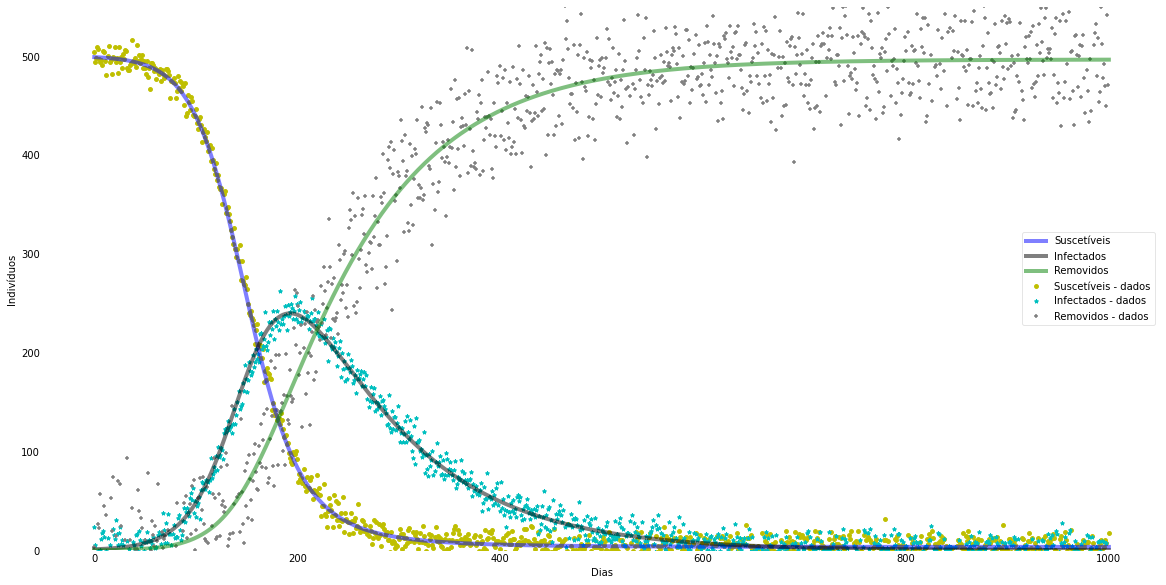

In [13]:
[Sa,Ia,Ra] = SIRsim(y0,t,c)

# Visualizando a evolução da Epidemia - S(t), I(t) e R(t)
fig = plt.figure(facecolor='w',figsize=(20,10))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, Sa, 'b', alpha=0.5, lw=4, label='Suscetíveis')
ax.plot(t, Ia, 'k', alpha=0.5, lw=4, label='Infectados')
ax.plot(t, Ra, 'g', alpha=0.5, lw=4, label='Removidos')
plt.scatter(t, Sd, marker='o', color='y', label='Suscetíveis - dados', s=15)
plt.scatter(t, Id, marker='*', color='c', label='Infectados - dados', s=15)
plt.scatter(t, Rd, marker='+', color='gray', label='Removidos - dados', s=15)
ax.set_xlabel('Dias')
ax.set_ylabel('Indivíduos')
ax.set_ylim(0, 550)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

# **Dados Reais**

Dados da COVID-19 no Brasil fornecidos por

- [Wesley Cota](https://github.com/wcota/covid19br)

In [14]:
# Reading data - wcota
data_path = 'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv'

df = pd.read_csv(data_path, delimiter=",") 
df.head()

,epi_week,date,country,state,city,newDeaths,deaths,newCases,totalCases,deathsMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,recovered,suspects,tests,tests_per_100k_inhabitants,vaccinated,vaccinated_per_100k_inhabitants,vaccinated_second,vaccinated_second_per_100k_inhabitants
0,9,2020-02-25,Brazil,SP,TOTAL,0,0,1,1,0,0,0.0,0.00218,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,2020-02-25,Brazil,TOTAL,TOTAL,0,0,1,1,0,0,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,2020-02-26,Brazil,SP,TOTAL,0,0,0,1,0,1,0.0,0.00218,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,2020-02-26,Brazil,TOTAL,TOTAL,0,0,0,1,0,1,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,2020-02-27,Brazil,SP,TOTAL,0,0,0,1,0,1,0.0,0.00218,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df.shape

(10206, 22)

In [16]:
df.isnull().sum()

epi_week                                     0
date                                         0
country                                      0
state                                        0
city                                         0
newDeaths                                    0
deaths                                       0
newCases                                     0
totalCases                                   0
deathsMS                                     0
totalCasesMS                                 0
deaths_per_100k_inhabitants                  0
totalCases_per_100k_inhabitants              0
deaths_by_totalCases                         0
recovered                                  643
suspects                                  2544
tests                                     1344
tests_per_100k_inhabitants                1344
vaccinated                                8731
vaccinated_per_100k_inhabitants           8731
vaccinated_second                         9411
vaccinated_se

## Maranhão

In [76]:
# Dataframe for Maranhão state
state = 'MA'
df_state = df[df.state == state].reset_index()
df_state.head()

,index,epi_week,date,country,state,city,newDeaths,deaths,newCases,totalCases,deathsMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,recovered,suspects,tests,tests_per_100k_inhabitants,vaccinated,vaccinated_per_100k_inhabitants,vaccinated_second,vaccinated_second_per_100k_inhabitants
0,220,12,2020-03-20,Brazil,MA,TOTAL,0,0,1,1,0,0,0.0,0.01413,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,247,12,2020-03-21,Brazil,MA,TOTAL,0,0,1,2,0,1,0.0,0.02827,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,275,13,2020-03-22,Brazil,MA,TOTAL,0,0,0,2,0,2,0.0,0.02827,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,303,13,2020-03-23,Brazil,MA,TOTAL,0,0,6,8,0,2,0.0,0.11307,0.0,NaN,302.0,NaN,NaN,NaN,NaN,NaN,NaN
4,331,13,2020-03-24,Brazil,MA,TOTAL,0,0,0,8,0,8,0.0,0.11307,0.0,NaN,302.0,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
# Creating new recovered column
df_state["newRecovered"] = df_state["recovered"].diff()
df_state.newRecovered.fillna(0, inplace=True)
df_state.recovered.fillna(0, inplace=True)

In [78]:
# Creating active cases column (Infected)
active_infected = [df_state["totalCases"].iloc[0]]
for nc, nr in zip(df_state["newCases"].iloc[1:], 
                  df_state["newRecovered"].iloc[1:]):
    active_infected.append(active_infected[-1] + nc - nr)
df_state["activeCases"] = active_infected

In [79]:
# Plotting the correct results components
fig = go.Figure()

fig.add_trace(go.Scatter(
    name="Active Cases",
    x=df_state.date,
    y=df_state.activeCases,
    mode='markers',
    marker=dict(size=6, color="#38006b")
    ))

fig.add_trace(go.Scatter(
    name="Recovered",
    x=df_state.date,
    y=df_state.recovered,
    mode='markers',
    marker=dict(size=6, color="#005005")
    ))

fig.update_layout(
    template='xgridoff',
    xaxis=dict(showgrid=False),
    xaxis_title='Date',
    yaxis_title='Individuals',
    legend=dict(
      orientation='h',
      yanchor='bottom',
      y=1.01,
      xanchor='right',
      x=0.95
      ),
    title_text="Real data")

fig.show()

In [80]:
# States population

import yaml

with open('/content/drive/MyDrive/Trabalho/Covid/Datasets/state_pop.yaml') as f:
    state_pop = yaml.load(f)

In [135]:
df_state_init = df_state.iloc[:70] # Days to find Beta and r 

# Size of population
N = 60000 
#N = state_pop['MA']['population']

# Data
Id = df_state_init["activeCases"]
Rd = df_state_init["recovered"]
Sd = N - Rd - Id

In [136]:
# Valores iniciais 
I0 = 1 
R0 = 0
S0 = N - I0

# Vetor de condições iniciais
y0 = S0, I0, R0

# Beta - taxa de contato,
# r - taxa média de recuperação (in 1/dia).

theta0 = [1e-4, 1e-2] # valores iniciais [Beta, r]

t = np.linspace(0, len(df_state_init.index.values), len(df_state_init.index.values))

In [137]:
# Simulating to find beta and r
(c, kvg) = optimize.leastsq(objetivo,theta0) 
print(c)

[3.28952339e-06 3.80846916e-02]


In [138]:
df_state_sim = df_state.iloc[:250] # Days to simulate
tsim = np.linspace(0, len(df_state_sim.index.values), len(df_state_sim.index.values))
[Ss,Is,Rs] = SIRsim(y0,tsim,c) # Finding S, I and R for the model

In [139]:
# Plotting the results
fig = go.Figure()

fig.add_trace(go.Scatter(
    name="Active Cases - Model",
    x=df_state_sim.date,
    y=Is,
    mode='lines',
    line=dict(width=3, dash="dash", color="#6a1b9a")
    ))

fig.add_trace(go.Scatter(
    name="Recovered - Model",
    x=df_state_sim.date,
    y=Rs,
    mode='lines',
    line=dict(width=3, dash="dash", color="#2e7d32")
    ))

fig.add_trace(go.Scatter(
    name="Susceptible - Model",
    x=df_state_sim.date,
    y=Ss,
    mode='lines',
    line=dict(width=3, dash="dash", color="#58ACFA")
    ))

fig.add_trace(go.Scatter(
    name="Active Cases - Data",
    x=df_state_sim.date,
    y=Id,
    mode='markers',
    marker=dict(size=6, color="#38006b")
    ))

fig.add_trace(go.Scatter(
    name="Recovered - Data",
    x=df_state_sim.date,
    y=Rd,
    mode='markers',
    marker=dict(size=6, color="#005005")
    ))

fig.add_trace(go.Scatter(
    name="Susceptible - Data",
    x=df_state_sim.date,
    y=Sd,
    mode='markers',
    marker=dict(size=6, color="#0080FF")
    ))

fig.update_layout(
    template='xgridoff',
    xaxis=dict(showgrid=False),
    xaxis_title='Days',
    yaxis_title='Individuals',
    legend=dict(
      orientation='h',
      yanchor='bottom',
      y=1.01,
      xanchor='right',
      x=0.95
      ),
    title_text="SIR Model")

fig.show()

## Espírito Santo

In [140]:
# Dataframe for Espírito Santo state
state = 'ES'
df_state = df[df.state == state].reset_index()
df_state.head()

,index,epi_week,date,country,state,city,newDeaths,deaths,newCases,totalCases,deathsMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,recovered,suspects,tests,tests_per_100k_inhabitants,vaccinated,vaccinated_per_100k_inhabitants,vaccinated_second,vaccinated_second_per_100k_inhabitants
0,22,10,2020-03-06,Brazil,ES,TOTAL,0,0,1,1,0,1,0.0,0.02488,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28,10,2020-03-07,Brazil,ES,TOTAL,0,0,0,1,0,1,0.0,0.02488,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,35,11,2020-03-08,Brazil,ES,TOTAL,0,0,0,1,0,1,0.0,0.02488,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,43,11,2020-03-09,Brazil,ES,TOTAL,0,0,0,1,0,1,0.0,0.02488,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,51,11,2020-03-10,Brazil,ES,TOTAL,0,0,0,1,0,1,0.0,0.02488,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
# Creating new recovered column
df_state["newRecovered"] = df_state["recovered"].diff()
df_state.newRecovered.fillna(0, inplace=True)
df_state.recovered.fillna(0, inplace=True)

In [142]:
# Creating active cases column (Infected)
active_infected = [df_state["totalCases"].iloc[0]]
for nc, nr in zip(df_state["newCases"].iloc[1:], 
                  df_state["newRecovered"].iloc[1:]):
    active_infected.append(active_infected[-1] + nc - nr)
df_state["activeCases"] = active_infected

In [143]:
# Plotting the correct results components
fig = go.Figure()

fig.add_trace(go.Scatter(
    name="Active Cases",
    x=df_state.index.values,
    y=df_state.activeCases,
    mode='markers',
    marker=dict(size=6, color="#38006b")
    ))

fig.add_trace(go.Scatter(
    name="Recovered",
    x=df_state.index.values,
    y=df_state.recovered,
    mode='markers',
    marker=dict(size=6, color="#005005")
    ))

fig.update_layout(
    template='xgridoff',
    xaxis=dict(showgrid=False),
    xaxis_title='Date',
    yaxis_title='Individuals',
    legend=dict(
      orientation='h',
      yanchor='bottom',
      y=1.01,
      xanchor='right',
      x=0.95
      ),
    title_text="Real data")

fig.show()

In [169]:
df_state_init = df_state.iloc[:100] # Days to find Beta and r 

# Size of population
N = 150000 
#N = state_pop['ES']['population']

# Data
Id = df_state_init["activeCases"]
Rd = df_state_init["recovered"]
Sd = N - Rd - Id

In [170]:
# Valores iniciais 
I0 = 1 
R0 = 0
S0 = N - I0

# Vetor de condições iniciais
y0 = S0, I0, R0

# Beta - taxa de contato,
# r - taxa média de recuperação (in 1/dia).

theta0 = [1e-4, 1e-2] # valores iniciais [Beta, r]

t = np.linspace(0, len(df_state_init.index.values), len(df_state_init.index.values))

In [171]:
# Simulating to find beta and r
(c, kvg) = optimize.leastsq(objetivo,theta0) 
print(c)

[1.35465490e-06 1.02733624e-01]


In [172]:
df_state_sim = df_state.iloc[:250] # Days to simulate
tsim = np.linspace(0, len(df_state_sim.index.values), len(df_state_sim.index.values))
[Ss,Is,Rs] = SIRsim(y0,tsim,c) # Finding S, I and R for the model

In [174]:
# Plotting the results
fig = go.Figure()

fig.add_trace(go.Scatter(
    name="Active Cases - Model",
    x=df_state_sim.date,
    y=Is,
    mode='lines',
    line=dict(width=3, dash="dash", color="#6a1b9a")
    ))

fig.add_trace(go.Scatter(
    name="Recovered - Model",
    x=df_state_sim.date,
    y=Rs,
    mode='lines',
    line=dict(width=3, dash="dash", color="#2e7d32")
    ))

fig.add_trace(go.Scatter(
    name="Susceptible - Model",
    x=df_state_sim.date,
    y=Ss,
    mode='lines',
    line=dict(width=3, dash="dash", color="#58ACFA")
    ))

fig.add_trace(go.Scatter(
    name="Active Cases - Data",
    x=df_state_sim.date,
    y=Id,
    mode='markers',
    marker=dict(size=6, color="#38006b")
    ))

fig.add_trace(go.Scatter(
    name="Recovered - Data",
    x=df_state_sim.date,
    y=Rd,
    mode='markers',
    marker=dict(size=6, color="#005005")
    ))

fig.add_trace(go.Scatter(
    name="Susceptible - Data",
    x=df_state_sim.date,
    y=Sd,
    mode='markers',
    marker=dict(size=6, color="#0080FF")
    ))

fig.update_layout(
    template='xgridoff',
    xaxis=dict(showgrid=False),
    xaxis_title='Days',
    yaxis_title='Individuals',
    legend=dict(
      orientation='h',
      yanchor='bottom',
      y=1.01,
      xanchor='right',
      x=0.95
      ),
    title_text="SIR Model")

fig.show()

## Tocantins

In [229]:
# Dataframe for Distrito Federal
state = 'TO'
df_state = df[df.state == state].reset_index()
df_state.head()

,index,epi_week,date,country,state,city,newDeaths,deaths,newCases,totalCases,deathsMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,recovered,suspects,tests,tests_per_100k_inhabitants,vaccinated,vaccinated_per_100k_inhabitants,vaccinated_second,vaccinated_second_per_100k_inhabitants
0,186,12,2020-03-18,Brazil,TO,TOTAL,0,0,1,1,0,0,0.0,0.06358,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,209,12,2020-03-19,Brazil,TO,TOTAL,0,0,0,1,0,1,0.0,0.06358,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,236,12,2020-03-20,Brazil,TO,TOTAL,0,0,0,1,0,1,0.0,0.06358,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,264,12,2020-03-21,Brazil,TO,TOTAL,0,0,1,2,0,2,0.0,0.12716,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,292,13,2020-03-22,Brazil,TO,TOTAL,0,0,3,5,0,2,0.0,0.31789,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [230]:
# Creating new recovered column
df_state["newRecovered"] = df_state["recovered"].diff()
df_state.newRecovered.fillna(0, inplace=True)
df_state.recovered.fillna(0, inplace=True)

In [231]:
# Creating active cases column (Infected)
active_infected = [df_state["totalCases"].iloc[0]]
for nc, nr in zip(df_state["newCases"].iloc[1:], 
                  df_state["newRecovered"].iloc[1:]):
    active_infected.append(active_infected[-1] + nc - nr)
df_state["activeCases"] = active_infected

In [232]:
# Plotting the correct results components
fig = go.Figure()

fig.add_trace(go.Scatter(
    name="Active Cases",
    x=df_state.index.values,
    y=df_state.activeCases,
    mode='markers',
    marker=dict(size=6, color="#38006b")
    ))

fig.add_trace(go.Scatter(
    name="Recovered",
    x=df_state.index.values,
    y=df_state.recovered,
    mode='markers',
    marker=dict(size=6, color="#005005")
    ))

fig.update_layout(
    template='xgridoff',
    xaxis=dict(showgrid=False),
    xaxis_title='Date',
    yaxis_title='Individuals',
    legend=dict(
      orientation='h',
      yanchor='bottom',
      y=1.01,
      xanchor='right',
      x=0.95
      ),
    title_text="Real data")

fig.show()

In [299]:
df_state_init = df_state.iloc[:130] # Days to find Beta and r 

# Size of population
N = 150000 #state_pop['TO']['population']

# Data
Id = df_state_init["activeCases"]
Rd = df_state_init["recovered"]
Sd = N - Rd - Id

In [300]:
# Valores iniciais 
I0 = 1 
R0 = 0
S0 = N - I0

# Vetor de condições iniciais
y0 = S0, I0, R0

# Beta - taxa de contato,
# r - taxa média de recuperação (in 1/dia).

theta0 = [1e-4, 1e-2] # valores iniciais [Beta, r]

t = np.linspace(0, len(df_state_init.index.values), len(df_state_init.index.values))

In [301]:
# Simulating to find beta and r
(c, kvg) = optimize.leastsq(objetivo,theta0) 
print(c)

[1.19770069e-06 1.04696676e-01]


In [302]:
df_state_sim = df_state.iloc[:250] # Days to simulate
tsim = np.linspace(0, len(df_state_sim.index.values), len(df_state_sim.index.values))
[Ss,Is,Rs] = SIRsim(y0,tsim,c) # Finding S, I and R for the model

In [303]:
# Plotting the results
fig = go.Figure()

fig.add_trace(go.Scatter(
    name="Active Cases - Model",
    x=df_state_sim.date,
    y=Is,
    mode='lines',
    line=dict(width=3, dash="dash", color="#6a1b9a")
    ))

fig.add_trace(go.Scatter(
    name="Recovered - Model",
    x=df_state_sim.date,
    y=Rs,
    mode='lines',
    line=dict(width=3, dash="dash", color="#2e7d32")
    ))

fig.add_trace(go.Scatter(
    name="Susceptible - Model",
    x=df_state_sim.date,
    y=Ss,
    mode='lines',
    line=dict(width=3, dash="dash", color="#58ACFA")
    ))

fig.add_trace(go.Scatter(
    name="Active Cases - Data",
    x=df_state_sim.date,
    y=Id,
    mode='markers',
    marker=dict(size=6, color="#38006b")
    ))

fig.add_trace(go.Scatter(
    name="Recovered - Data",
    x=df_state_sim.date,
    y=Rd,
    mode='markers',
    marker=dict(size=6, color="#005005")
    ))

fig.add_trace(go.Scatter(
    name="Susceptible - Data",
    x=df_state_sim.date,
    y=Sd,
    mode='markers',
    marker=dict(size=6, color="#0080FF")
    ))

fig.update_layout(
    template='xgridoff',
    xaxis=dict(showgrid=False),
    xaxis_title='Days',
    yaxis_title='Individuals',
    legend=dict(
      orientation='h',
      yanchor='bottom',
      y=1.01,
      xanchor='right',
      x=0.95
      ),
    title_text="SIR Model")

fig.show()